Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.
(32, 64, 64, 3)
(32,)
1.0


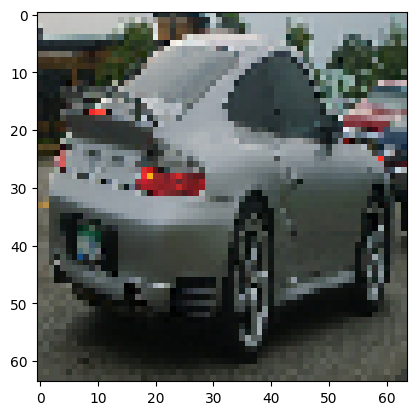

In [19]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import os
data_gen = ImageDataGenerator(
    rescale=1.0/255
    )
data_gen_aug = ImageDataGenerator(
                rescale=1.0/255,
                horizontal_flip = True,
                vertical_flip = True )


img_size = 64
batch_size = 32

train_generator = data_gen_aug.flow_from_directory(
        './train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Xbatch_aug, Ybatch_aug = train_generator.next()

train_generator = data_gen.flow_from_directory(
        './train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Xbatch, Ybatch = train_generator.next()

validation_generator = data_gen.flow_from_directory(
        './validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

x_test, y_test = validation_generator.next()

print(Xbatch.shape)
print(Ybatch.shape)
print(Ybatch[0])
plt.imshow(Xbatch[0])

In [20]:
def make_convnet():
    model = Sequential()
    model.add(Conv2D(8,(3,3), activation="relu",input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16,(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer=(SGD(learning_rate=0.01,momentum=0.1, nesterov=True)),
              metrics=['accuracy'])
    return model

model = make_convnet()
model_aug = make_convnet()

#model.summary()
epochs=50
history = model.fit(Xbatch, Ybatch,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
history_aug = model_aug.fit(Xbatch_aug, Ybatch_aug,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))
score_aug = model_aug.evaluate(x_test, y_test, verbose=0)
print('Augmented Test loss:', score_aug[0])
print('Augmented Test accuracy:', score_aug[1])

Test loss: 0.6797422766685486
Test accuracy: 0.59375
Augmented Test loss: 0.6795482635498047
Augmented Test accuracy: 0.59375


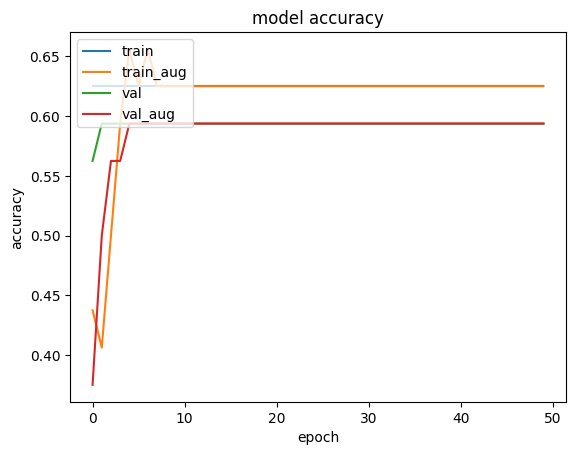

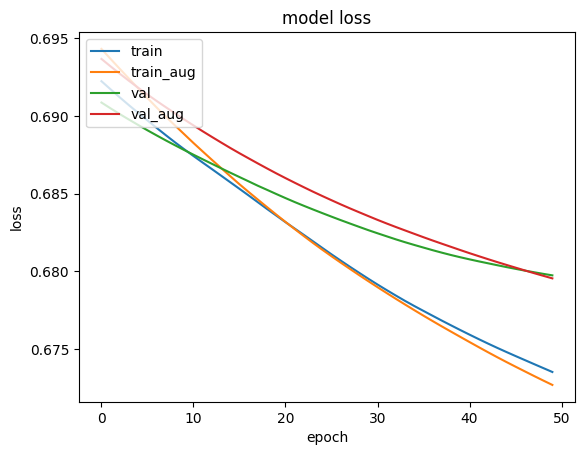

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history_aug.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','train_aug', 'val','val_aug'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history_aug.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','train_aug', 'val','val_aug'], loc='upper left')
plt.show()

With the chosen CNN the accuracy score is the same but the loss is lower on the augmented data, not by much though.

In [22]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

image = load_img('./train/car/0005.jpg',target_size=(224,224))
image_array = img_to_array(image)
image_preprocessed = preprocess_input(image_array)
image_final = image_preprocessed.reshape(1,224,224,3)
prediction = vggmodel.predict(image_final)
decode_predictions(prediction)

35363/35363 [==============================] - 0s 1us/step


[[('n03345487', 'fire_engine', 0.2906942),
  ('n04461696', 'tow_truck', 0.22112109),
  ('n03478589', 'half_track', 0.10861475),
  ('n04037443', 'racer', 0.10831271),
  ('n04389033', 'tank', 0.052309267)]]

The image is a racecar and "racer" is included in the prediction. Furthermore the primary prediction is a vehicle of some sort 

In [23]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
def create_vgg16_features(directory, file):
        vgg_train_generator = vgg_data_gen.flow_from_directory(
                directory,
                target_size=(img_size, img_size),
                batch_size=batch_size,
                class_mode='binary',
                classes=['other', 'car'],
                seed=12345,
                shuffle=False)
        cnn_features= feature_extractor.predict(vgg_train_generator)
        with open(file, 'wb') as f:
                np.save(f, cnn_features)

create_vgg16_features('./train/', './train.txt')
create_vgg16_features('./validation/', './validation.txt')





58889256/58889256 [==============================] - 3s 0us/step
Found 1600 images belonging to 2 classes.
50/50 [==============================] - 43s 861ms/step
Found 576 images belonging to 2 classes.
18/18 [==============================] - 15s 831ms/step


In [25]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))


def train_on_cnnfeatures(): 
  with open('./train.txt', 'rb') as f:
    train_data = np.load(f)
  with open('./validation.txt', 'rb') as f:
    validation_data = np.load(f)
  model = Sequential()
  model.add(Flatten())
  model.compile(loss='binary_crossentropy',
              optimizer=(SGD(learning_rate=0.01,momentum=0.1, nesterov=True)),
              metrics=['accuracy'])
  labels_train = get_labels(1600)
  labels_val = get_labels(576)
  model.fit(train_data, labels_train,
            batch_size=batch_size,
            epochs=10,
            verbose=1,
            validation_data= (validation_data,labels_val))
  score = model.evaluate(validation_data, labels_val, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

train_on_cnnfeatures()  



Epoch 1/10
50/50 [==============================] - 1s 7ms/step - loss: 7.8951 - accuracy: 0.0000e+00 - val_loss: 7.8859 - val_accuracy: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 4ms/step - loss: 7.8951 - accuracy: 0.0000e+00 - val_loss: 7.8859 - val_accuracy: 0.0000e+00
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: 7.8951 - accuracy: 0.0000e+00 - val_loss: 7.8859 - val_accuracy: 0.0000e+00
Epoch 4/10
50/50 [==============================] - 0s 4ms/step - loss: 7.8951 - accuracy: 0.0000e+00 - val_loss: 7.8859 - val_accuracy: 0.0000e+00
Epoch 5/10
50/50 [==============================] - 0s 4ms/step - loss: 7.8951 - accuracy: 0.0000e+00 - val_loss: 7.8859 - val_accuracy: 0.0000e+00
Epoch 6/10
50/50 [==============================] - 0s 4ms/step - loss: 7.8951 - accuracy: 0.0000e+00 - val_loss: 7.8859 - val_accuracy: 0.0000e+00
Epoch 7/10
50/50 [==============================] - 0s 4ms/step - loss: 7.8951 - accuracy: 0.0000e+00 - val_loss